Manifold learning - Parte 1/2
---
1. MDS
2. LLE
---

Jonnatan Arias Garcia

jonnatan.arias@utp.edu.co

jariasg@uniquindio.edu.co

**Manifold Learning**

Si bien PCA es flexible, rápido y fácil de interpretar, no funciona tan bien cuando hay relaciones no lineales dentro de los datos, algunos ejemplos de los cuales veremos en breve.

Para abordar esta deficiencia, podemos recurrir a algoritmos de aprendizaje de variedades, una clase de estimadores no supervisados que buscan describir conjuntos de datos como variedades de baja dimensión incrustadas en espacios de alta dimensión.

En el lenguaje del manifold learning, puedes pensar en esta hoja como una variedad bidimensional incrustada en un espacio tridimensional. Rotar, reorientar o estirar la hoja de papel en el espacio tridimensional no cambia su geometría plana: tales operaciones son similares a incrustaciones lineales. Si doblas, rizas o arrugas el papel, sigue siendo una variedad bidimensional, pero el embedding en el espacio tridimensional ya no es lineal. Los algoritmos de aprendizaje de manifold buscan aprender sobre la naturaleza fundamental bidimensional del papel, incluso cuando se retuerce para llenar el espacio tridimensional.

Aquí examinaremos varios métodos de manifold, adentrándonos más en un subconjunto de estas técnicas: escalamiento multidimensional (MDS), incrustación lineal local (LLE) y mapeo isométrico (Isomap).

Comenzamos con las importaciones estándar:

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

<ipython-input-31-cd9e54b682e8>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Data "HELLO"
Generaremos datos 2D para definir el manifold.
aquie tenemos una funcion que crea la palabra Hello

In [32]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)

    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

<ipython-input-33-52e289940de9>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))


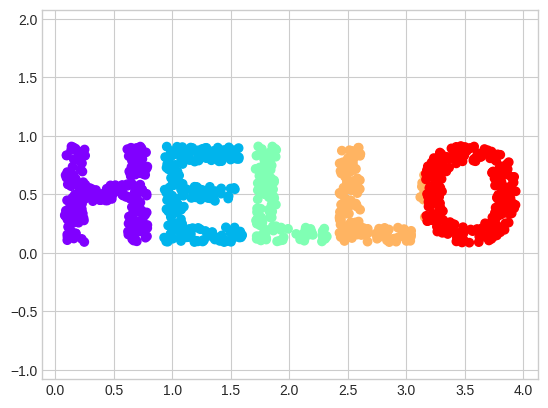

In [33]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

## MDS - Multidimensional Scaling

Podemos ver que las elecciones particulares de los valores de x e y del conjunto de datos no son la descripción más fundamental de los datos: podemos escalar, reducir o rotar los datos, y el "HELLO" seguirá siendo evidente.

Por ejemplo, si usamos una matriz de rotación para girar los datos, los valores de x e y cambian, pero los datos siguen siendo fundamentalmente los mismos

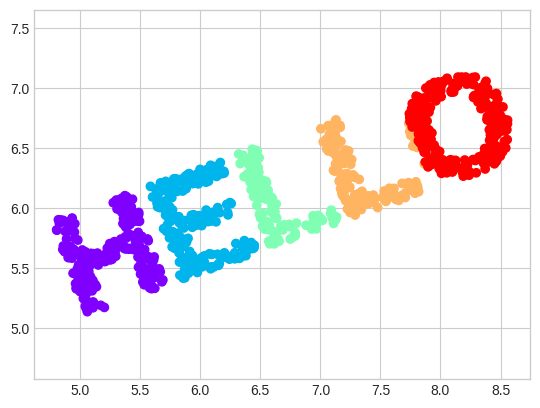

In [34]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

Esto confirma que los valores de x e y no son necesariamente fundamentales para las relaciones en los datos.
Lo fundamental, en este caso, es la distancia entre cada punto dentro del conjunto de datos.

Una forma común de representar esto es usar una matriz de distancias: para N puntos, construimos una matriz N×N de tal manera que la entrada (i,j) contiene la distancia entre el punto i y el punto j.

¡Vamos a usar la función eficiente pairwise_distances de Scikit-Learn para hacer esto con nuestros datos originales!

In [35]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

Para nuestros N=1,000 puntos, obtenemos una matriz de 1000 × 1000, la cual se puede visualizar como se muestra aquí:

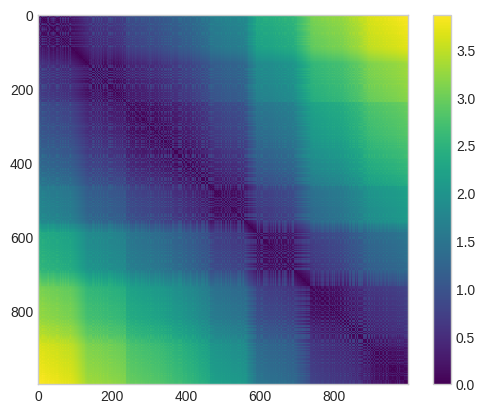

In [36]:
plt.imshow(D, zorder=2, cmap='viridis', interpolation='nearest')
plt.colorbar();

Si construimos de manera similar una matriz de distancias para nuestros datos rotados y traducidos, vemos que es la misma:

In [37]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

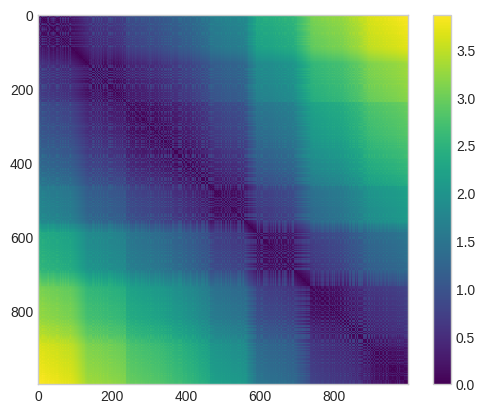

In [38]:
plt.imshow(D2, zorder=2, cmap='viridis', interpolation='nearest')
plt.colorbar();

Esta matriz de distancia nos da una representación de nuestros datos que es invariante a rotaciones y traslaciones, pero la visualización de la matriz en la siguiente figura no es del todo intuitiva. En la representación mostrada allí, hemos perdido cualquier signo visible de la estructura interesante en los datos: el "HELLO" que vimos antes.

Además, mientras que calcular esta matriz de distancia a partir de las coordenadas (x, y) es sencillo, transformar las distancias de vuelta en coordenadas x e y es bastante difícil.
Esto es exactamente lo que el algoritmo de escalamiento multidimensional pretende hacer: dado una matriz de distancia entre puntos, recupera una representación de coordenadas en D dimensiones de los datos. Veamos cómo funciona para nuestra matriz de distancia, utilizando la disimilaridad precalculada para especificar que estamos pasando una matriz de distancia

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


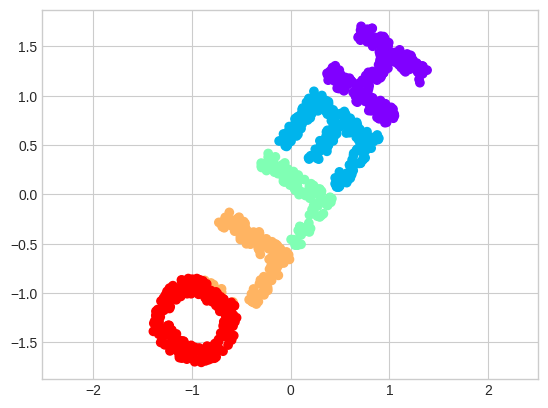

In [39]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1701)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

El algoritmo MDS recupera una de las posibles representaciones bidimensionales de nuestras datos, utilizando solamente la matriz de distancias N×N que describe la relación entre los puntos de datos.

### MDS como Manifold Learning

La utilidad de esto se vuelve más evidente cuando consideramos el hecho de que las matrices de distancia se pueden calcular a partir de datos en cualquier dimensión.
Por ejemplo, en lugar de simplemente rotar los datos en el plano bidimensional, podemos proyectarlos en tres dimensiones usando la siguiente función (esencialmente una generalización tridimensional de la matriz de rotación utilizada anteriormente):

In [40]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)
X3.shape

(1000, 3)

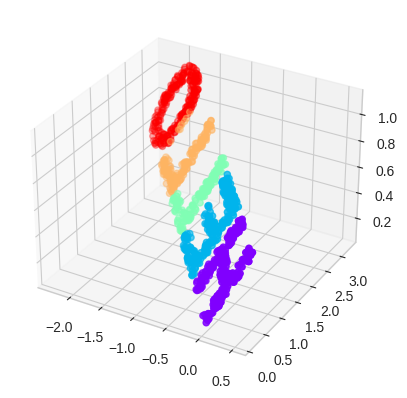

In [41]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize);

Podemos ahora pedirle al estimador MDS que ingrese estos datos tridimensionales, calcule la matriz de distancias y luego determine el mejor embebido bidimensional para esta matriz de distancias.
El resultado recupera una representación de los datos originales, como se muestra en la siguiente figura:

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


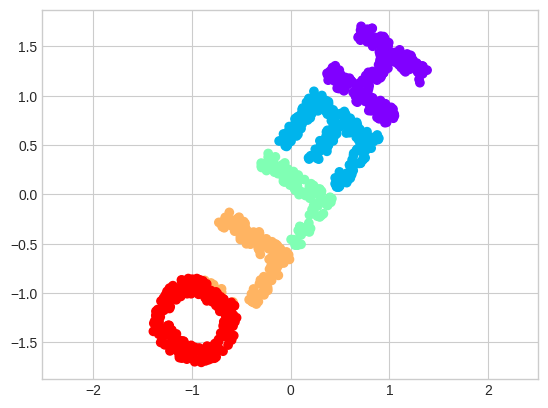

In [42]:
model = MDS(n_components=2, random_state=1701)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

Este es básicamente el objetivo de un estimador de aprendizaje de variedades: dado un conjunto de datos incrustados en alta dimensión, busca una representación en baja dimensión de los datos que conserve ciertas relaciones dentro de los datos. En el caso de MDS, la cantidad preservada es la distancia entre cada par de puntos.

### Nonlinear Embeddings: Donde MDS Falla

Hasta ahora, nuestra discusión ha considerado embeddings lineales, que básicamente consisten en rotaciones, traslaciones y escalados de datos en espacios de dimensiones superiores.

Donde falla el MDS es cuando la incrustación es no lineal, es decir, cuando va más allá de este simple conjunto de operaciones. Considera la siguiente embedding, que toma la entrada y la retuerce en una forma de "S" en tres dimensiones:

In [43]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

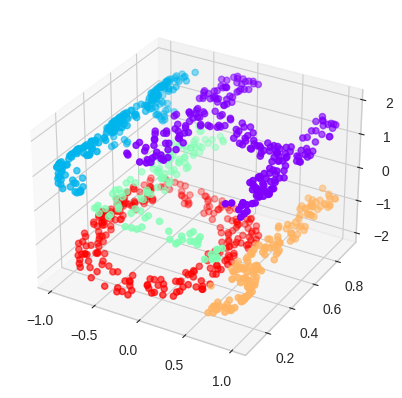

In [44]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

Las relaciones fundamentales entre los puntos de datos siguen ahí, pero esta vez los datos han sido transformados de una manera no lineal: se han envuelto en la forma de una "S".

Si intentamos un algoritmo MDS simple en estos datos, no es capaz de "desenvolver" este incrustamiento no lineal, y perdemos la pista de las relaciones fundamentales en el manifolds incrustado

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


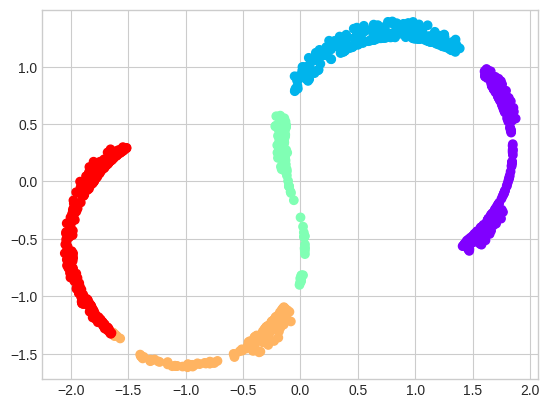

In [45]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

La mejor incrustación lineal bidimensional no desenrolla la curva en S, sino que en cambio descarta el eje y original.

## Locally Linear Embedding - LLE

¿Cómo podemos avanzar aquí? Retrocediendo un poco, podemos ver que la fuente del problema es que MDS intenta preservar distancias entre puntos lejanos al construir la incrustación. Pero ¿qué pasaría si en cambio modificamos el algoritmo de manera que solo preserve distancias entre puntos cercanos? La incrustación resultante estaría más cerca de lo que queremos.

Visualmente, podemos pensarlo como se ilustra en esta figura:

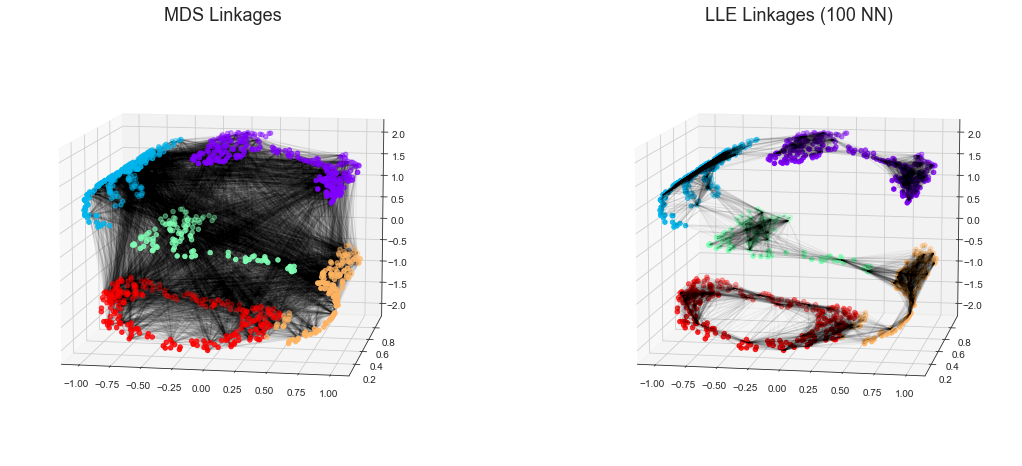

Aquí cada línea tenue representa una distancia que debe ser preservada en el embedding. A la izquierda hay una representación del modelo utilizado por MDS: intenta preservar las distancias entre cada par de puntos en el conjunto de datos. A la derecha hay una representación del modelo utilizado por un algoritmo de aprendizaje de manifold llamado LLE: en lugar de preservar todas las distancias, intenta preservar solo las distancias entre puntos vecinos (en este caso, los 100 vecinos más cercanos de cada punto).

Al pensar en el panel izquierdo, podemos ver por qué falla MDS: no hay forma de desenrollar estos datos mientras se preserva adecuadamente la longitud de cada línea dibujada entre los dos puntos. Por otro lado, para el panel derecho, las cosas parecen un poco más optimistas. Podríamos imaginar desenrollar los datos de manera que mantenga aproximadamente las mismas longitudes de las líneas. Esto es precisamente lo que hace LLE, a través de una optimización global de una función de costo que refleja esta lógica.

LLE viene en varios tipos; aquí utilizaremos el algoritmo LLE modificado para recuperar la variedad bidimensional incrustada. En general, LLE modificado funciona mejor que otros algoritmos para recuperar variedades bien definidas con muy poca distorsión

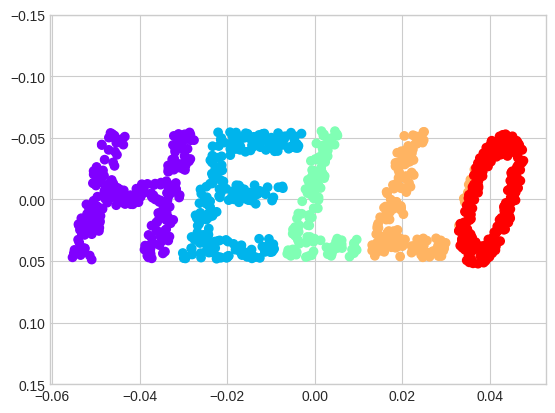

In [46]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(
    n_neighbors=100, n_components=2,
    method='modified', eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

El resultado sigue estando algo distorsionado en comparación con nuestro manifold original, ¡pero captura las relaciones esenciales en los datos!

## Apuntes sobre Manifold Methods

Aunque estos ejemplos pueden resultar convincentes, en la práctica las técnicas de aprendizaje de variedades tienden a ser lo suficientemente quisquillosas como para que rara vez se utilicen para algo más que una simple visualización cualitativa de datos de alta dimensión.

A continuación se presentan algunos de los desafíos particulares del aprendizaje de manifold, que contrastan notablemente con el PCA:

* En el aprendizaje de manifolds, no hay un buen marco para manejar datos faltantes. En contraste, existen enfoques iterativos directos para tratar con datos faltantes en el PCA.
* En el aprendizaje de manifolds, la presencia de ruido en los datos puede "cortocircuitar" el manifold y cambiar drásticamente el embedding. En contraste, el PCA filtra naturalmente el ruido de los componentes más importantes.
* El resultado del embedding en el manifold generalmente depende en gran medida del número de vecinos elegidos, y generalmente no hay una forma cuantitativa sólida de elegir un número óptimo de vecinos. En contraste, el PCA no implica tal elección.
* En el aprendizaje de manifolds, es difícil determinar el número óptimo global de dimensiones de salida. En contraste, el PCA te permite encontrar el número de dimensiones de salida en función de la varianza explicada.
* En el aprendizaje de manifolds, el significado de las dimensiones incrustadas no siempre es claro. En el PCA, los componentes principales tienen un significado muy claro.
* En el aprendizaje de manifolds, el gasto computacional de los métodos de variedades escala como  O[N2]  o  O[N3] . Para el PCA, existen enfoques aleatorizados que generalmente son mucho más rápidos (aunque se puede consultar el paquete megaman para algunas implementaciones de aprendizaje de manifolds más escalables).
[*megaman* package](https://github.com/mmp2/megaman)

Con todo eso sobre la mesa, la única ventaja clara de los métodos de aprendizaje de manifold sobre el PCA es su capacidad para preservar relaciones no lineales en los datos; por esa razón tiendo a explorar los datos con métodos de manifold solo después de explorarlos primero con PCA.

Scikit-Learn implementa varias variantes comunes de aprendizaje de manifolds más allá de LLE e Isomap: la documentación de Scikit-Learn tiene una buena discusión y comparación de ellos. Basado en mi propia experiencia, daría las siguientes recomendaciones:

* Para problemas simples como la curva en S que vimos antes, LLE y sus variantes (especialmente LLE modificado) funcionan muy bien. Esto está implementado en sklearn.manifold.LocallyLinearEmbedding.

* Para datos de alta dimensionalidad de fuentes del mundo real, LLE a menudo produce resultados pobres, y Isomap parece generalmente llevar a incrustaciones más significativas. Esto está implementado en sklearn.manifold.Isomap.
* Para datos altamente agrupados, el embebido estocástico de vecinos t-distribuidos (t-SNE) parece funcionar muy bien, aunque puede ser muy lento en comparación con otros métodos. Esto está implementado en sklearn.manifold.TSNE.
